Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 05: Eye tracking

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 28, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

For this exercise sheet you will have 2 weeks and the sheet is also worth of 30 points. In this exercise sheet you will start to work with eye tracking data. Note that the data we will use here are not raw gaze data and contain coordinates of fixation points.

The dataset is distributed freely by a following study: [Wilming, N. Dryad](https://www.nature.com/articles/sdata2016126#data-citations). By clicking on the link in the section "Data Citations" you will get redirected to the page where you can download all the data openly distributed. Read below for description of each file.

##### necessary
*etdb_v1.0*: This is the main data file. The hdf5 file consists of all the fixation data and the metadata.  
*Read gaze data with python*: Python script to read hdf5 file as a dataframe.  
*Stimuli/i*: Zip file containing image stimuli used in the study. The encoding convention is same as in the dataframe.
##### optional
*Metadata*: This is the csv file giving overview of all studies.

In [1]:
#%pip install h5py # make sure to install h5py which is used in fixmat.py

In [2]:
import os
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import *
from datas.fixmat import *
from scipy.stats import norm
from statsmodels.formula.api import ols
from IPython.display import HTML as html_print

## Assignment 0: Peer review for sheet 04 [3 pts]

Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week. Follow a distributed comment guidelines if you are unsure.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 5, 9 | 1, 6  | 4, 7  | 7, 2 | 2, 11 | 8, 3 | 3, 10  | 11, 1  | 10, 4  | 6, 8  | 9, 5   |


## Assignment 1: Checking the data distribution [9 pts]

### a) loading datasets [0 pts]
As with any other datasets, the first step is to get an idea of the dataset. Check the meta data and column of the dataframe.

In [3]:
# use a fixmat.py to load the hdf5 format data as a panda dataframe
PATH = os.getcwd()
df, meta = load(PATH + '/datas/etdb_v1.0.hdf5', "Baseline")
df.head()

,SUBJECTINDEX,category,dataset_nr,end,eye,filenumber,fix,pupil,start,trial,x,y
0,1.0,11.0,3.0,215.0,2.0,25.0,1.0,3287.901123,-183.0,1.0,636.0,489.0
1,1.0,11.0,3.0,503.0,2.0,25.0,2.0,2872.182129,261.0,1.0,524.0,276.0
2,1.0,11.0,3.0,819.0,2.0,25.0,3.0,2452.396484,541.0,1.0,592.0,393.0
3,1.0,11.0,3.0,1103.0,2.0,25.0,4.0,2135.433594,865.0,1.0,367.0,339.0
4,1.0,11.0,3.0,1399.0,2.0,25.0,5.0,2007.327393,1145.0,1.0,196.0,364.0


In [4]:
meta

{'# Fix.': 203772,
 '# Obs.': 48,
 'Age': '23.1 (19-28)',
 'Article': 15.0,
 'Categories': '7,8,10,11',
 'Disp. Size (degree)': '29x22',
 'Display': 'SM1100',
 'Display resolution (pixels)': '1280x960',
 'Eye Tracker': 'EL II',
 'ID': 3,
 'Img. Pos. (pixel)': '0,0',
 'Img. size (pixel)': '1280x960',
 'PPD': 45.6,
 'Sampling freq. (Hz)': '500 Hz',
 'Task': 'FV',
 'V. Dur.': '6s',
 'V. dist. (cm) ': 80,
 'Val. error (degrees)': 0.3}

In [5]:
df.columns

Index(['SUBJECTINDEX', 'category', 'dataset_nr', 'end', 'eye', 'filenumber',
       'fix', 'pupil', 'start', 'trial', 'x', 'y'],
      dtype='object')

In [6]:
# trials are named the same for different subjects; for the sake of
# an easier data-handling I add a column to the dataframe with a unique
# code for each trial over all subjects: SUBJECTINDEX-trial

df['sub_trial'] = df['SUBJECTINDEX'] * 10000 + df['trial']

### b) data cleaning [3 pts]
We want to clean the dataframe so that it is handy for us to work with it.
- How many fixations do we have per category? ```agg``` function might be helpful.
- categories are encoded using a number. Add a column to the dataframe that has approporiate string value for that category (e.g. code 11.0 to "Pink-noise"). The category names can be found on Figure 2 of the paper.
- since measurements lasted for 6 seconds, any fixation points that have a onset time before 0 sec and end time more than 6 sec are erroneous. Remove these rows.
- also remove all rows with any NaN values.
- add a column called ```duration``` and compute the duration of each fixation.
- It is known from previous literature that fixations typically last between 100 msec to 400 msec. Remove all rows with unrealistic  fixation duration.
- check how many data points got removed for each category. Let's hope that we didn't delete too many rows from a single category.
- count the number of fixations for each trial. To do this, you can use the aggregate method to count the number of rows for each category.
- print the mean duration and the mean number of fixation across all trials. Are they in a realistic range?

In [7]:
# count the number of fixations for each category
print('The number of fixation points per category: \n')
fix_per_cat = df.groupby(['category']).fix.agg('count')
print(fix_per_cat, '\n\n')

# add a new column with categories labels
df['category_str'] = np.where(df['category'] == 7, 'Natural',
                    (np.where(df['category'] == 8, 'Urban',
                    (np.where(df['category'] == 10, 'Fractals', 'Pink-noise')))))

# remove the erroneous entries with negative onset and bigger than 6000ms end time
df_clean = df[(df.start >= 0) & (df.end <= 6000)].dropna()

# add the new column, duration, for the length of each experiment
df_clean['duration'] = df_clean['end'] - df_clean['start']

# remove the 'unrealistic' fixation durations
df_clean = df_clean[(df_clean.duration >= 100) & (df_clean.duration <= 400)]

# calculate and print out the number of removed data points from each category
print('\nRemoved data points per category:\n')
for category in df['category_str'].unique():
    
    # the number of data points in the category before data cleaning
    before = len(df[(df.category_str == category)])
    # the number of data points in the category after data cleaning
    after = len(df_clean[(df_clean.category_str == category)])
    # calculate the removal percentage
    pctg = (before - after) / before
    
    print('{} data points were removed from the "{}" category ({:.0%})'.format(before - after, category, pctg))


# count the number of fixations for each subject per trial
fix_per_trial = df_clean.groupby(['sub_trial']).fix.count()
print('\n\n\nThe number of fixation points per sub-image/-trial for each subject:\n')
print(fix_per_trial.head())


# calculate and print the mean duration and mean number of fixations across all trials
mean_dur = np.round(df_clean.duration.mean(), 2)
mean_fix = np.round(df_clean.groupby(['sub_trial']).trial.count().mean(), 2)
print('\n\nThe mean duration over all trials:', mean_dur)
print('The mean number of fixation points over all trials:', mean_fix)

The number of fixation points per category: 

category
7.0     52338
8.0     56680
10.0    52901
11.0    41853
Name: fix, dtype: int64 



Removed data points per category:

14603 data points were removed from the "Pink-noise" category (35%)
11835 data points were removed from the "Urban" category (21%)
12554 data points were removed from the "Natural" category (24%)
12979 data points were removed from the "Fractals" category (25%)



The number of fixation points per sub-image/-trial for each subject:

sub_trial
10001.0    15
10002.0    22
10003.0    15
10004.0    17
10005.0    17
Name: fix, dtype: int64


The mean duration over all trials: 240.49
The mean number of fixation points over all trials: 12.55


### c) visualizing data distribution [3 pts]
Are there any inter-subject difference and effect of different category in our data?
- plot the mean duration for each category (4 x-values) and the mean duration for each subject (48 x-values).

- plot the mean number of fixations for each category (4 x-values) and the mean number of fixation for each subject (48 x-values).

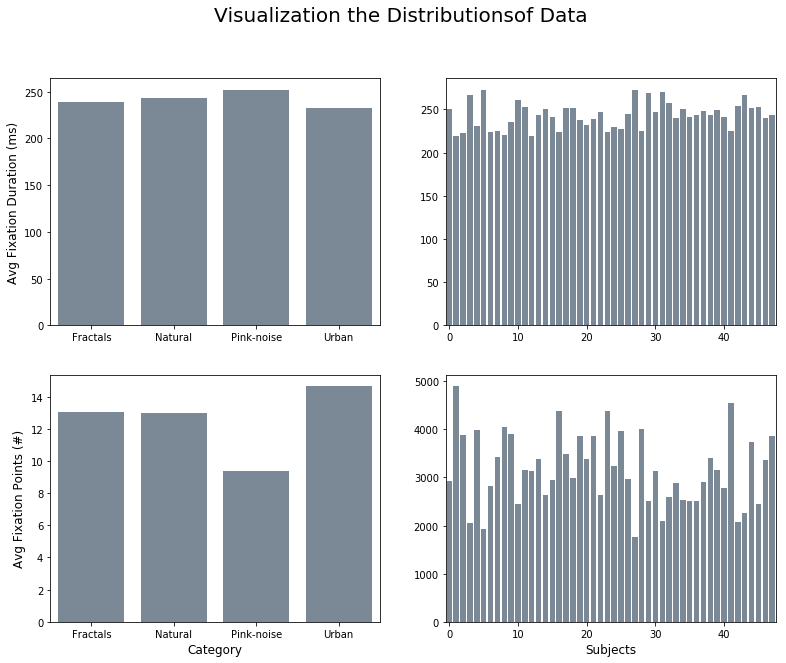

In [8]:
# make 4 subplots and a title
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,10))
figs.suptitle('Visualization the Distributionsof Data', fontsize=20)

# upper left plot
# calculate mean duration for each category
avg_dur_cat = df_clean.groupby(['category_str'], as_index=False).duration.mean()
# and its bar plot
sns.barplot(data=avg_dur_cat, x='category_str', y='duration',
               ax=axes[0,0], color='lightslategray')

# upper right plot
# calculate mean duration for each subject
avg_dur_sub = df_clean.groupby(['SUBJECTINDEX'], as_index=False).duration.mean()
# and its bar plot
sns.barplot(data=avg_dur_sub, x='SUBJECTINDEX', y='duration',
               ax=axes[0,1], color='lightslategray')

# lower left plot
# calculate mean number of fixations for images in each category
avg_fix_cat = df_clean.groupby(['category_str', 'sub_trial'],
                               as_index=False).trial.count()
# and its bar plot
sns.barplot(data=avg_fix_cat, x='category_str', y='trial',
               ax=axes[1,0], color='lightslategray', ci=None)

# lower right plot
# calculate mean number of fixations for images for each subject
avg_fix_sub = df_clean.groupby(['SUBJECTINDEX'], as_index=False).trial.count()
# and its bar plot
sns.barplot(data=avg_fix_sub, x='SUBJECTINDEX', y='trial',
               ax=axes[1,1], color='lightslategray')



# set the labels and tickbars
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Avg Fixation Duration (ms)', fontsize=12)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_xticklabels(np.arange(0,49,10))
axes[0,1].set_xticks(axes[0,1].get_xticks()[0:49:10])
axes[1,0].set_xlabel('Category', fontsize=12)
axes[1,0].set_ylabel('Avg Fixation Points (#)', fontsize=12)
axes[1,1].set_xlabel('Subjects', fontsize=12)
axes[1,1].set_ylabel('')
axes[1,1].set_xticklabels(np.arange(0,49,10))
axes[1,1].set_xticks(axes[1,1].get_xticks()[0:49:10]);

### d) normally distributed data [3 pts]
As ANOVA and lots of other statistical tests can be used only for normally distributed varaibles, it makes sense to find out whether the fixation duration and the number of fixations per trial is also normally distributed. This can be done with a Q-Q-Plot, which  is a graphical technique for determining if two data sets come from populations with a common distribution, in this case a normal distribution (for more information, klick [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33o.htm)).
- make a Q-Q plot of the variable *fixation duration*. Is it approximately normally distributed?
- make a Q-Q plot of the variable *# fixation per trial*. Is it approximately normally distributed?

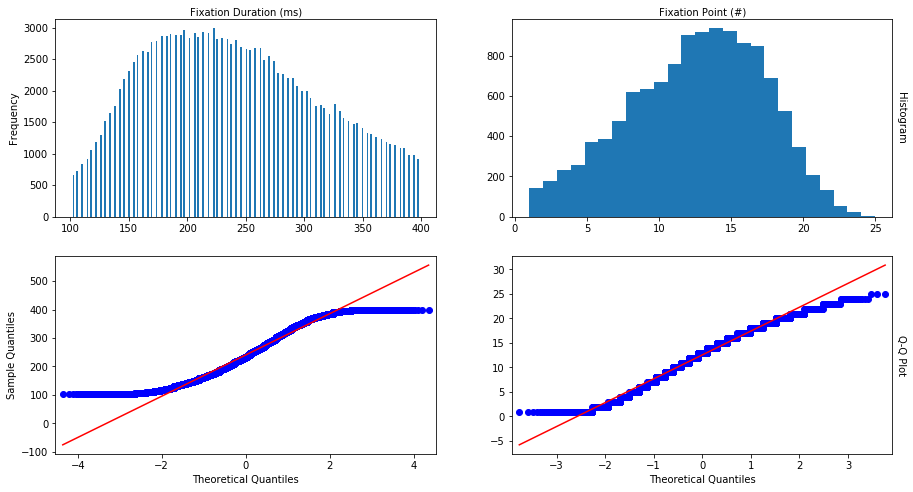

In [9]:
# set the stage for 4 plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

# I already calculated dataseries for fixation duration and number
# but for the sake of code readability I add these two lines here
fix_dur = df_clean.duration
fix_num = df_clean.groupby(['sub_trial']).fix.count()


# check the distributions using histograms
axes[0,0].hist(fix_dur, bins=200)
axes[0,1].hist(fix_num, bins=25)


# draw Q-Q plot for the fixation durations and the number of fixation points
prob = sm.ProbPlot(fix_dur, dist='norm')
prob.qqplot(line='r', ax=axes[1,0])

prob = sm.ProbPlot(fix_num, dist='norm')
prob.qqplot(line='r', ax=axes[1,1])


# set the labels and tickbars
axes[0,0].set_xlabel('Fixation Duration (ms)')
axes[0,0].xaxis.set_label_position('top')
axes[0,0].set_ylabel('Frequency')
axes[0,1].set_xlabel('Fixation Point (#)')
axes[0,1].xaxis.set_label_position('top')
axes[0,1].set_ylabel('Histogram', labelpad=14)
axes[0,1].yaxis.set_label_position('right')
axes[0,1].yaxis.label.set_rotation(-90)
axes[1,1].set_ylabel('Q-Q Plot', labelpad=14)
axes[1,1].yaxis.set_label_position('right')
axes[1,1].yaxis.label.set_rotation(-90);

what do you think?

**What do you mean what I think? I think even numbers are nice while odd numbers are vicious. I also think 'N' and 'M' are a couple; N is the woman and she is a shrew, while M is a humble and shy man.**

**Please be specific about your questions!**

**Anyway, as we can see our distributions are normal, though roughly. And the problem is more acute in the case of fixation duration distribution.**
**But as Robert Geary once said: 'Normality is a myth; there never was, and never will be, a normal distribution.' So unlike my teammates, I still feel like these two distributions are real-life normals. Especially if we consider that their biggest probelm for being considered normal is their cut tails, which were in fact cut by ourselves. Remember when we were cleaning data for duration values not in the range of 100-400 ms, right? What will stop us from assuming that we actually had some truthful measurements of under 100 and over 400 ms? But then we filter them out, as noise.**

**So... yup, normal, cool!**


****

## Assignment 2: Hypothesis testing [3 pts]

### a) one way ANOVA [3 pts]
Now it's time to really prove our intuition. Test the following null hypotheses:  
$H01$: There is no difference in fixation duration across 4 different categories.  
$H02$: There is no difference in the number of fixations across 4 different categories.

What do you find?

In [10]:
# H01
# Outcome: fixation duration
# Predictor: category

# create an OLS model between categories and duration
model = ols('duration ~ category_str', data=df_clean).fit()

# calculate one-way ANOVA for the null hypothesis: H01
table = anova_lm(model, typ=1)
print('One-way ANOVA for testing how fixation duration is affected by category:\n')
print(table)

One-way ANOVA for testing how fixation duration is affected by category:

                    df        sum_sq       mean_sq           F         PR(>F)
category_str       3.0  6.918205e+06  2.306068e+06  431.192133  5.622037e-279
Residual      151797.0  8.118290e+08  5.348123e+03         NaN            NaN


In [11]:
# H02
# Outcome: number of fixation points
# Predictor: category

# create the required dataframe with a column for the number of fixation per sub-trial
fix_num = df_clean.groupby(['category_str', 'sub_trial']).fix.count().reset_index()

# create an OLS model between categories and duration
model = ols('fix ~ category_str', data=fix_num).fit()

# calculate one-way ANOVA for the null hypothesis: H02
table = anova_lm(model, typ=1)
print('One-way ANOVA for testing how the number of fixation points is affected by category:\n')
print(table)

One-way ANOVA for testing how the number of fixation points is affected by category:

                   df         sum_sq       mean_sq           F  PR(>F)
category_str      3.0   44079.250345  14693.083448  719.753527     0.0
Residual      12090.0  246805.847141     20.414049         NaN     NaN


what do you say?

**Considering the p-values, which are almost zero, we can assume that outcome is significantly predictable by the independent variables in both case. So we can reject both null hypothese.**

**But I have a problem here. When we are comparing different categories distribution with one outcome or 'dependent' variable, should not we first check the normality of distribution for each of categories, rather than overall categories?**

**I also have another question; why when I use the column 'category' instead of 'category_str' (that is, using the labels 7, 8, 10, & 11 instead of 'Natural,' 'Urban,' 'Pink-noise,' & 'fractals' the degree of freedon reduces to 1, like we have only 2 categories?**

****

## Assignment 3: Binning [4 pts]

### a) distribution of # fixation [2 pts]
Now we would like to know if there's a difference in terms of fixation numbers at different time segment.
- make a histogram with x axis being the start time of fixation
- the bin size should be 1 sec. In total there would be 6 bins.
- average over all subjects and images, just make a one simple plot
- figure out mean fixation duration for each bin and print it


### On Binning

**As my teammate explained it clearly we should not use 1-sec bins, cause during data pre-processing based on the essential features of data (like considering a fixed range for fixation duration or the 6-sec time of the observation) the latest possible fixation starting-time that we could theoretically have in our data samples is the one that starts at 5900. So the correct range for binning is from 0 to 5900. So we could either not take the last bin into account or divide the available range into approximation of 1000 ms, like 1180 (so again 5 bins). Since the accuracy of time measurement is 1 ms, so we cannot use bins with smaller fractions of time. So i guess the only thing left to do is to use 5 bins, either by ignoring the last 1-sec or by using 1180-ms bin width.**

**I decided to go with ignoring the last bin. Cause for this left-bias check, we are mainly focused on the first bins and earlier fixations, rather than latest ones.**

**But wait a minute!**
**Asume we have fewer data points in the last bin, which is the case for sure, but then so what?**
**It does not affect the average duration of that few remained fixations and their x-values!**
**The only thing that this affect is the frequency of datapoints in the last bin, so just the histogram, and nothing else. Right?**



ATTENTION: THE RESULTS FOR THE LAST BIN IS ERRONEOUS AND SHOULD BE IGNORED AS IT WAS EXPLAINED IN THE PREVIOUS CELL.
 

The average fixation duration for each bin:

bin
0    232.820251
1    242.930771
2    242.886093
3    243.198181
4    243.334625
5    236.727753
Name: duration, dtype: float32


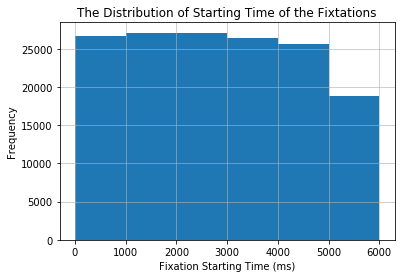

In [12]:
# Histogram
# ------------------
# plot the histogram
# plt.figure(figsize=(8,8))
plt.hist(df_clean.start, bins=[0, 1000, 2000, 3000, 4000, 5000, 6000])

# do the dirty works
plt.title('The Distribution of Starting Time of the Fixtations')
plt.grid(alpha=0.75)
plt.xlabel('Fixation Starting Time (ms)')
plt.ylabel('Frequency');



# Average Fixation Duration
# -------------------------
# add a column bin to our dataframe
df_clean['bin'] = np.floor(df_clean.start / 1000).apply(lambda x: int(x))

# calculate the mean duration for each bin
bin_fix_avg = df_clean.groupby(['bin']).duration.mean()

# and print them out
print('\n\n' + '\033[1m' + '\033[91m' + 'ATTENTION: THE RESULTS FOR THE LAST BIN IS',
      'ERRONEOUS AND SHOULD BE IGNORED AS IT WAS EXPLAINED IN THE PREVIOUS CELL.\n','\033[0m')

print('\nThe average fixation duration for each bin:\n')
print(bin_fix_avg)


### b) leftward bias [2 pts]
If you took Action & Cognition I, you have probably heard about the leftward bias in human's fixation behavior. It is known that people tend to look more at the left visual field for the initial first second. Check whether this holds for our dataset as well.
- make a pointplot with x-axis as the x-coordinate of each fixation point and y-axis as the time bin to which the fixation point belongs to.
- mark the confidence interval around each point.
- make a vertical line at middle point of the x values. The x-coordinate of the fixation point in the data is based on the coordinate system using the display resolution. You can find out the information about display resolution by taking a look at the meta data.

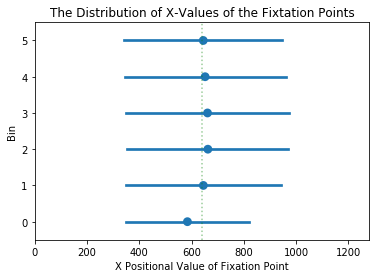

In [13]:
# save the x-values in a list of dataSeries
# add a new column with categories labels

# make the bin column categorical for the pointplot
df_clean['bin'] = df_clean['bin'].astype('category')

# plot the data
# plt.figure(figsize=(8,8))
sns.pointplot(x ='x', y='bin', order=[5,4,3,2,1,0], data=df_clean, join=False, ci='sd')

# and the dirty adornment job for the plot
plt.title('The Distribution of X-Values of the Fixtation Points')
plt.xlabel('X Positional Value of Fixation Point')
plt.xlim([0,1280]) # using meta data about the images width (1280)
plt.ylabel('Bin')

# and draw a vertical line representing the center of the images at x-axis
# using the meta data on the image width (1280)
plt.axvline(x=640, color='g', linestyle=':', alpha=.4);


## Assignment 4: Heatmap [4 pts]
Now let's use heatmap to visualize which part of pictures is fixated for how long. It would be also good to know if there's a difference between categories.
- make a heatmap for data consisting of each categories and then averaged across all data.
- mark a central point in the plot.
- you can use ```numpy.histogram2d``` to compute a bi-dimensional histogram.
- then you can use ```pyplot.imshow``` to plot these histogram.
- don't forget to use the parameter ```extent``` to control for the bounding box to which the image should fit in.
- if you want to use other functions that's surely fine as well.

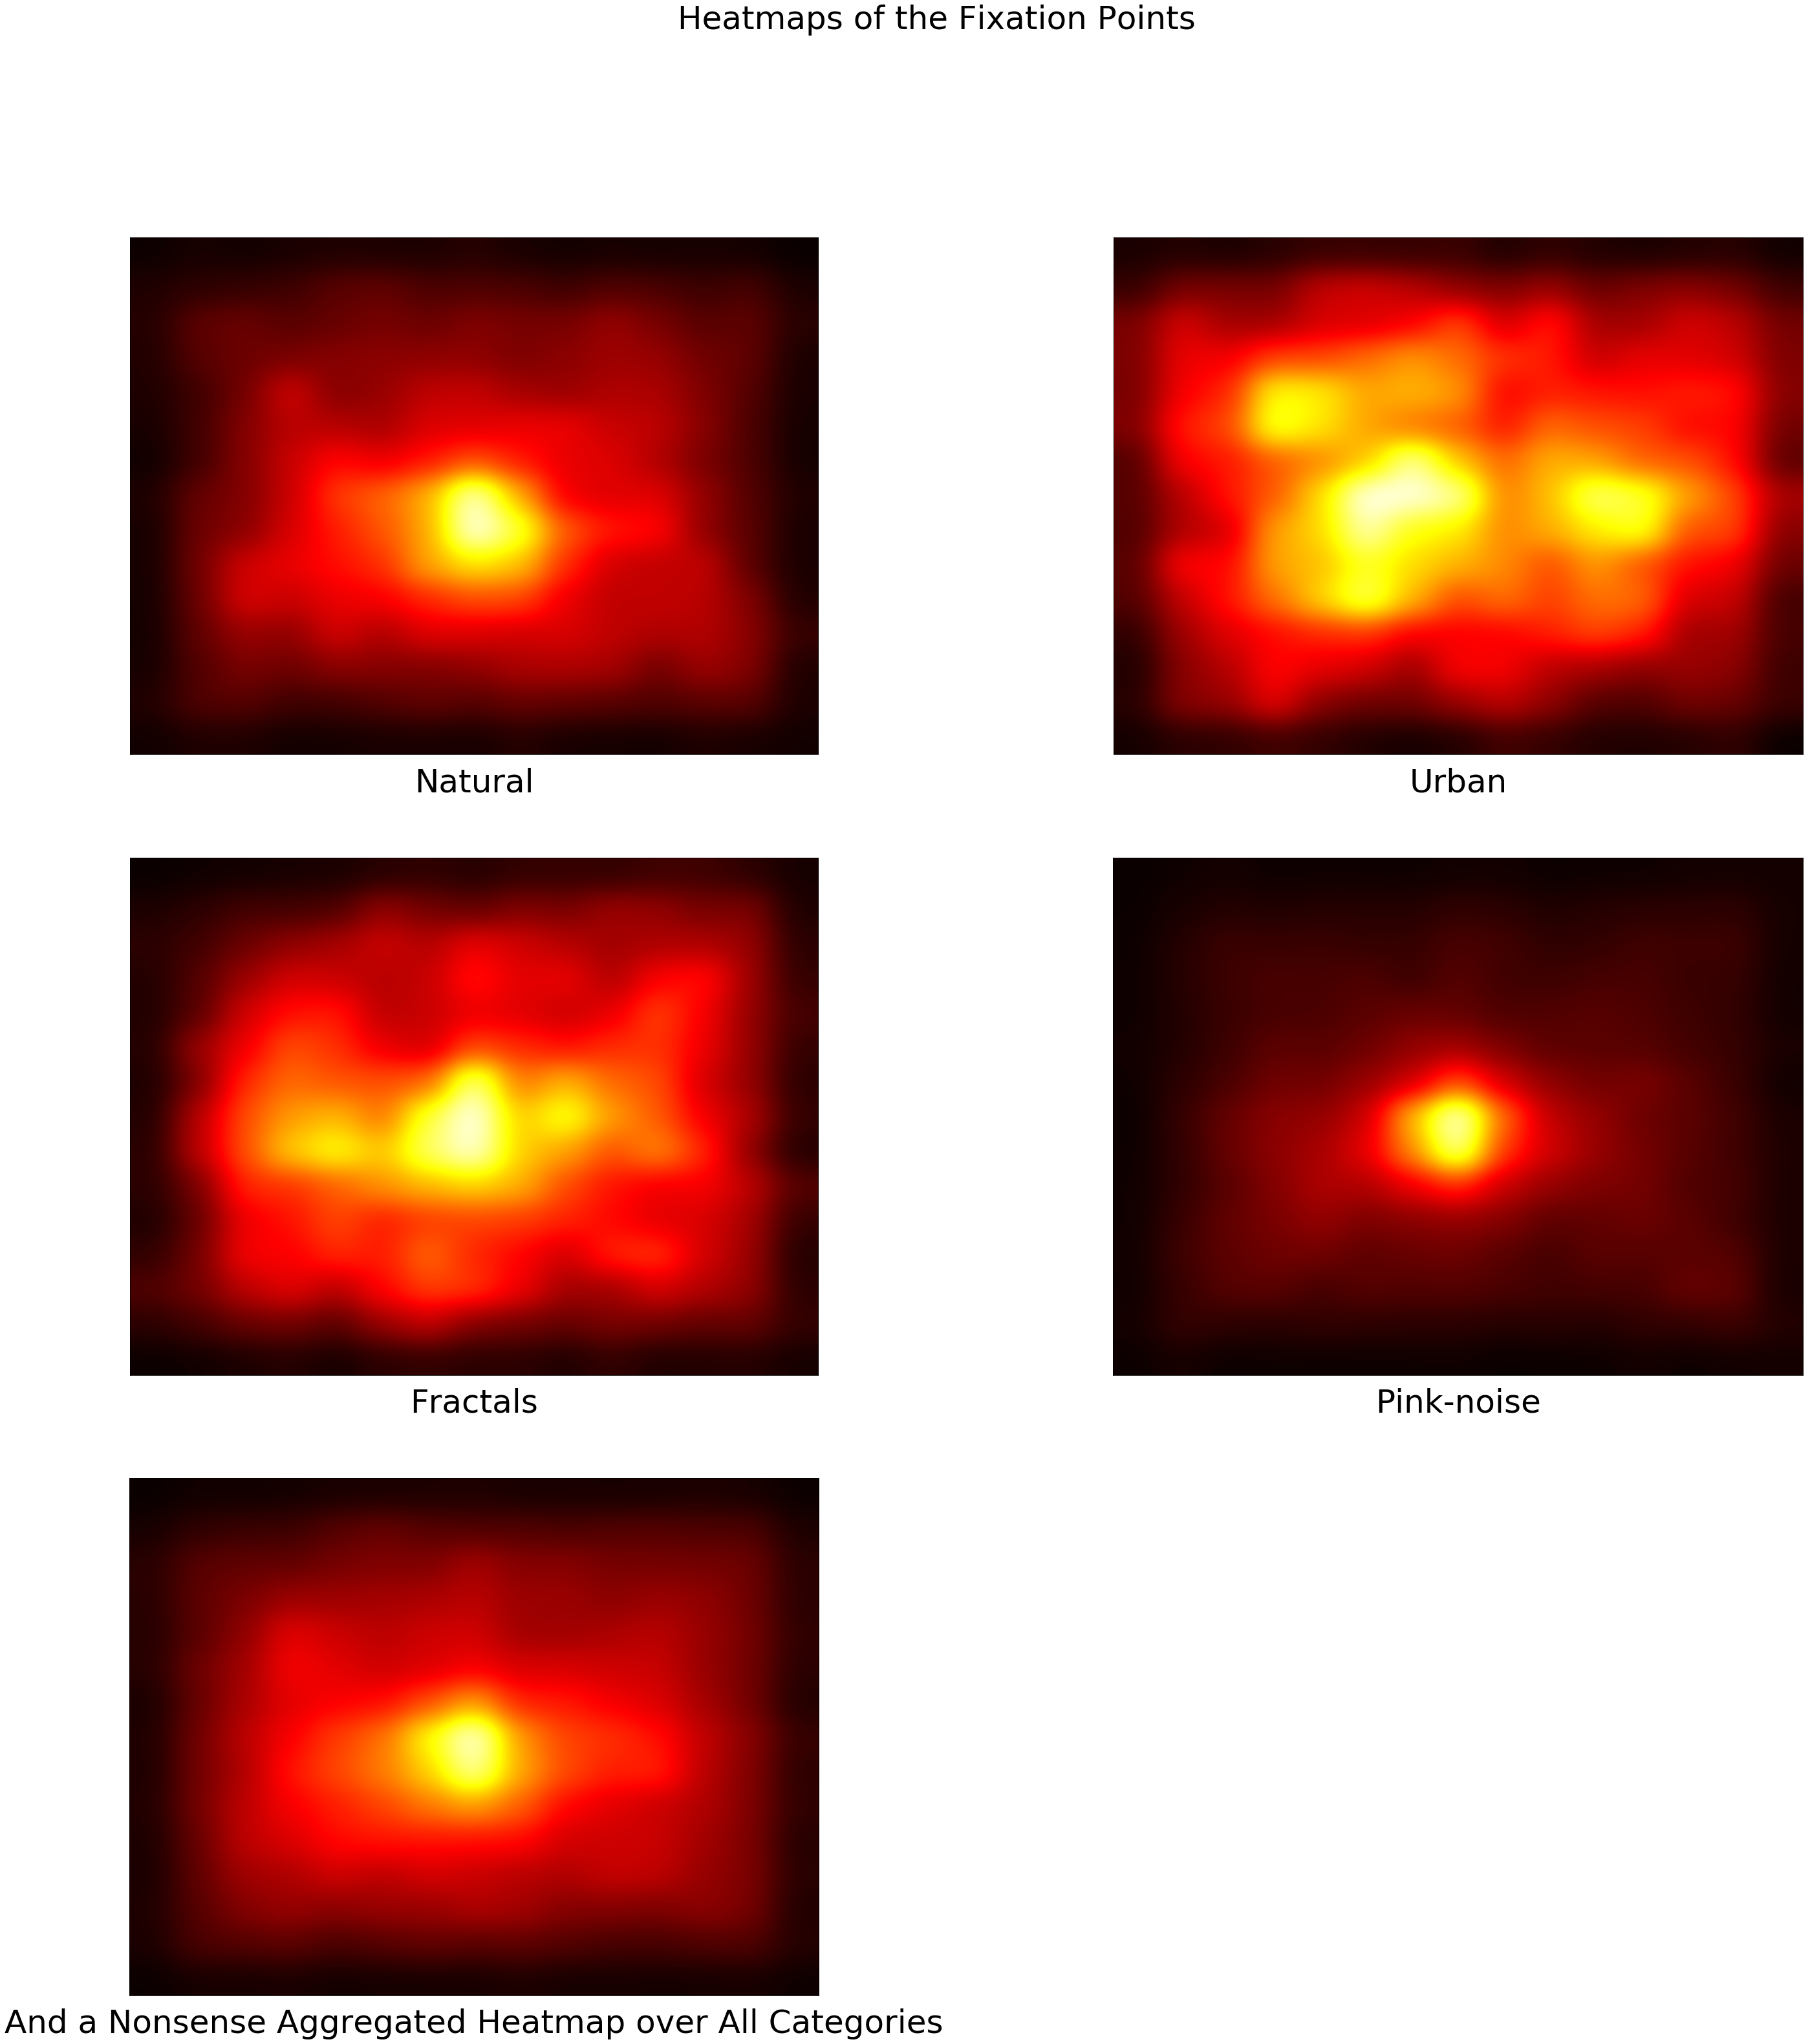

In [58]:
# define a function for plotting heatmaps
def heatmap(ax, category, bins):
    '''This function takes the category and plots a heatmap using the
    x and y positional values of all the fixation points on images
    belong to that category, on taken argument 'ax' axis, with the
    taken 'bins' resolution
    '''
    # take the x/y positional values from the dataframe
    x_vals = df_clean[df_clean.category_str == category]['x']
    y_vals = df_clean[df_clean.category_str == category]['y']
    # set the 2D-histogram
    H, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=bins, density=True)
    ax.imshow(H.T, interpolation='gaussian', origin='lower', cmap='hot',
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    # take care of plot labels, ticks, and sizes
    ax.set_xlim(xedges[0], xedges[-1])
    ax.set_ylim(yedges[0], yedges[-1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(str(category), fontsize=50, labelpad=20)

# set the space for 5 plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(50, 50))
fig.suptitle('Heatmaps of the Fixation Points', fontsize=50)
fig.delaxes(axes[2,1])

# and plot heatmaps
heatmap(axes[0,0], 'Natural', 15)
heatmap(axes[0,1], 'Urban', 15)
heatmap(axes[1,0], 'Fractals', 15)
heatmap(axes[1,1], 'Pink-noise', 15)

# plot an averaged heatmap over all categories; but why? Just tell me! WHY?
H, xedges, yedges = np.histogram2d(df_clean.x, df_clean.y, bins=15, density=True)
axes[2,0].imshow(H.T, interpolation='gaussian', origin='lower', cmap='hot',
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# and take care of plot label and ticks
axes[2,0].set_xticks([])
axes[2,0].set_yticks([])
axes[2,0].set_xlabel('And a Nonsense Aggregated Heatmap over All Categories', fontsize=50, labelpad=20);



## Assignment 5: Scanpath [5 pts]
We want to know whether different scan behaviour is used when viewing images of different categories. Scanpath is a path followed by the eyes when viewing a stimulus. Scanpaths are useful for analyzing cognitive intent, interest, and salience. It has an advantage to a heatmap because the information about temporal structure of viewing behaviour can be plotted.
- make four plots, one for each category.
- randomely choose one trial for which you will plot a scanpath.
- mark fixation points based on the x-y coordinates.
- plot the *saccade path* from one fixation point to another one.
- make sure that the order of fixation can be read out from the plot. E.g. earlier fixations could have a light color whereas later fixations could have dark colors.
- also include information about the duration of each fixation. One way to do it is the use the size of the fixation marker.
- plot the background image superimposed with the scanpath. 

In [15]:
# make 4 subplots and a title
#figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,10))
#figs.suptitle('Scanpath for Different Categories', fontsize=24)


def draw_scanpath(category, fixations, saccades, dispsize, imagefile=None, alpha=0.5, savefilename=None):

    """Draws a scanpath: a series of arrows between numbered fixations,
    optionally drawn over an image
    arguments

    fixations       -   a list of fixation ending events from a single trial,
                    as produced by edfreader.read_edf, e.g.
                    edfdata[trialnr]['events']['Efix']
    saccades        -   a list of saccade ending events from a single trial,
                    as produced by edfreader.read_edf, e.g.
                    edfdata[trialnr]['events']['Esac']
    dispsize        -   tuple or list indicating the size of the display,
                    e.g. (1024,768)

    keyword arguments

    imagefile  -    full path to an image file over which the heatmap
                    is to be laid, or None for no image; NOTE: the image
                    may be smaller than the display size, the function
                    assumes that the image was presented at the centre of
                    the display (default = None)
    alpha       -   float between 0 and 1, indicating the transparancy of
                    the heatmap, where 0 is completely transparant and 1
                    is completely untransparant (default = 0.5)
    savefilename    -    full path to the file in which the heatmap should be
                    saved, or None to not save the file (default = None)

    returns

    fig         -   a matplotlib.pyplot Figure instance, containing the
                    heatmap
    """
    
    random_filenumber = random.choice(np.arange(1,64))
    imagefile = str('datas/' + str(category) + '/' + str(filenumber) + '.png')
    random_subject = random.choice(np.arange(1,85))

    
    # image
    fig, ax = draw_display(dispsize, imagefile=imagefile)

    # FIXATIONS
    # parse fixations
    fix = parse_fixations(fixations)
    # draw fixations
    ax.scatter(fix['x'],fix['y'], s=fix['dur'], c=COLS['chameleon'][2], marker='o', cmap='jet', alpha=alpha, edgecolors='none')
    # draw annotations (fixation numbers)
    for i in range(len(fixations)):
        ax.annotate(str(i+1), (fix['x'][i],fix['y'][i]), color=COLS['aluminium'][5], alpha=1, horizontalalignment='center', verticalalignment='center', multialignment='center')

    # SACCADES
    if saccades:
        # loop through all saccades
        for st, et, dur, sx, sy, ex, ey in saccades:
            # draw an arrow between every saccade start and ending
            ax.arrow(sx, sy, ex-sx, ey-sy, alpha=alpha, fc=COLS['aluminium'][0], ec=COLS['aluminium'][5], fill=True, shape='full', width=10, head_width=20, head_starts_at_zero=False, overhang=0)

    # invert the y axis, as (0,0) is top left on a display
    ax.invert_yaxis()
    # save the figure if a file name was provided
    if savefilename != None:
        fig.savefig(savefilename)

    return fig

def parse_fixations(fixations):

    """Returns all relevant data from a list of fixation ending events

    arguments

    fixations   -   a list of fixation ending events from a single trial,
                    as produced by edfreader.read_edf, e.g.
                    edfdata[trialnr]['events']['Efix']
    returns

    fix    -    a dict with three keys: 'x', 'y', and 'dur' (each contain
                a numpy array) for the x and y coordinates and duration of
                each fixation
    """

    # empty arrays to contain fixation coordinates
    fix = {	'x':numpy.zeros(len(fixations)),
            'y':numpy.zeros(len(fixations)),
            'dur':numpy.zeros(len(fixations))}
    # get all fixation coordinates
    for fixnr in range(len( fixations)):
        stime, etime, dur, ex, ey = fixations[fixnr]
        fix['x'][fixnr] = ex
        fix['y'][fixnr] = ey
        fix['dur'][fixnr] = dur

    return fix

def draw_display(dispsize, imagefile=None):

    """Returns a matplotlib.pyplot Figure and its axes, with a size of
    dispsize, a black background colour, and optionally with an image drawn
    onto it

    arguments

    dispsize        -   tuple or list indicating the size of the display,
                    e.g. (1024,768)
    
    keyword arguments
    
    imagefile       -   full path to an image file over which the heatmap
                    is to be laid, or None for no image; NOTE: the image
                    may be smaller than the display size, the function
                    assumes that the image was presented at the centre of
                    the display (default = None)
    
    returns
    fig, ax     -   matplotlib.pyplot Figure and its axes: field of zeros
                    with a size of dispsize, and an image drawn onto it
                    if an imagefile was passed
    """

    # construct screen (black background)
    screen = numpy.zeros((dispsize[1],dispsize[0],3), dtype='uint8')
    # if an image location has been passed, draw the image
    if imagefile != None:
        # check if the path to the image exists
        if not os.path.isfile(imagefile):
            raise Exception("ERROR in draw_display: imagefile not found at '%s'" % imagefile)
        # load image
        img = image.imread(imagefile)
        # flip image over the horizontal axis
        # (do not do so on Windows, as the image appears to be loaded with
        # the correct side up there; what's up with that? :/)
        if not os.name == 'nt':
            img = numpy.flipud(img)
        # width and height of the image
        w, h = len(img[0]), len(img)
        # x and y position of the image on the display
        x = dispsize[0]/2 - w/2
        y = dispsize[1]/2 - h/2
        # draw the image on the screen
        screen[y:y+h,x:x+w,:] += img
    # dots per inch
    dpi = 100.0
    # determine the figure size in inches
    figsize = (dispsize[0]/dpi, dispsize[1]/dpi)
    # create a figure
    fig = pyplot.figure(figsize=figsize, dpi=dpi, frameon=False)
    ax = pyplot.Axes(fig, [0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    # plot display
    ax.axis([0,dispsize[0],0,dispsize[1]])
    ax.imshow(screen)#, origin='upper')

    return fig, ax

# Citation
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) An extensive dataset of eye movements during viewing of complex images. Scientific Data 4: 160126. https://doi.org/10.1038/sdata.2016.126  
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) Data from: An extensive dataset of eye movements during viewing of complex images. Dryad Digital Repository. https://doi.org/10.5061/dryad.9pf75